# Black-Scholes-Merton Option Replication & Delta Hedging <br>
Whitney Rueckl <br>
Original project: Fall 2021 <br>
Edited and expanded on: Summer 2022

The purpose of this notebook is to explore the BSM option manufacturing process by simulating a delta hedged portoflo.

#### Notebook outline:
- User defined functions
- Delta Hedging
- Get Option and Underlying Data (source: Yahoo Finance)
- Delta hedging simulation <br>
&nbsp; - Profit and loss outcome when implied volatility = realized volatility <br>
&nbsp; - Profit and loss outcome when implied volatility <> realized volatility
- Effect of increasing hedging frequency (hedging frequency = frequency of rebalancing back to delta neutral)



#### Loading Packages

In [1]:
import os
import sys
#sys.version

import numpy as np
import pandas as pd
import pandas_datareader as pdr
pd.options.display.max_rows = 10
from datetime import datetime

import matplotlib.pyplot as plt

# several functions from the py_vollib package for calculating option greeks:
from py_vollib.black_scholes_merton import black_scholes_merton
from py_vollib.black_scholes_merton.greeks.analytical import delta
from py_vollib.black_scholes_merton.greeks.analytical import vega
from py_vollib.black_scholes_merton.implied_volatility import implied_volatility

# Packges to pull market data (yahoo)
from yahoo_fin import stock_info as si
from yahoo_fin import options as op

# Using the handcalcs.render library to display formulas in LaTeX-like form
from handcalcs import render

C:\Users\whitn\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## User defined functions

#### Functions to pull stock and options data:  `getStockdata()` and `getOptionData()` <br>
NOTE: the **yahoo_fin.stock_info** and **yahoo_fin.options** libraries must be loaded for these functions to work

In [2]:
def getStockData(tickers, start_dt, end_dt):
    
    """
    Pulls historical stock price data using the yahoo_fin.stock_info module:
        
    Arguments:
        tickers: list of strings
        start_dt: list of float or int
        end_dt: list of float or int

    Returns:
         A dataframe of historical stock data
    
    """
    
    dict_stocks = {}

    for tick in tickers: 
    
        dict_stocks[tick] = si.get_data(tick, start_date = start_dt, end_date = end_dt)
    
    df_stocks = pd.concat(dict_stocks).reset_index()
    df_stocks.rename(columns={'level_1': 'date'}, inplace = True)
    df_stocks.columns = df_stocks.columns.str.lower().str.replace(' ', '_')
        
    return df_stocks

In [3]:
def getOptionData(tickers, cp_flag, exp_date):
    
    """
    Pulls option price data using the yahoo_fin.options module
        
    Arguments:
        tickers: list of strings
        cp_flag: string, either 'c' for a call or 'p' for a put
        exp_date: option expiration date 

    Returns:
        A dataframe of option data
    
    Note: 
    Use yahoo_fin.options.get_expiration_dates(ticker) to view all available expiration dates
    
    """

    dict_options ={}

    # if the cp_flag is 'c' (call option), get call data using the op.get_calls() function
    if cp_flag == 'c':
        for tick in tickers:
            dict_options[tick] = op.get_calls(ticker = tick, date = exp_date)
            dict_options[tick]['stock_ticker'] = tick
    # if the cp_flag is 'p' (put option), get call data using the op.get_puts() function            
    if cp_flag == 'p':
        for tick in tickers:
            dict_options[tick] = op.get_puts(ticker = tick, date = exp_date)
            dict_options[tick]['stock_ticker'] = tick
            
    df_options = pd.concat(dict_options) #.reset_index()
    df_options.columns = df_options.columns.str.lower().str.replace(' ', '_')
    
    return df_options

#### Vectorizing `py_vollib` Functions

The functions `bsm_px()`, `bsm_delta()`, and `bsm_vega()` are defined below. These user defined functions allow a few of the `py_vollib` functions to be used in a vecorized manner.

In [96]:
def bsm_px(row):
    cp = row['cp']
    upx = row['upx']
    strike = row['strike']
    t2x = row['t2x']
    rf = 0
    volatility = row['volatility']
    q = 0
    px = black_scholes_merton(cp, upx, strike, t2x, rf, volatility, q)
    px = np.round(px, 2)
    return(px)

In [97]:
def bsm_delta(row):
    cp = row['cp']
    upx = row['upx']
    strike = row['strike']
    t2x = row['t2x']
    rf = 0
    volatility = row['volatility']
    q = 0
    if t2x == 0:
        return(0)
    diff = delta(cp, upx, strike, t2x, rf, volatility, q)
    diff = np.round(diff, 3)
    return(diff)

In [98]:
def bsm_vega(row):
    cp = row['cp']
    upx = row['upx']
    strike = row['strike']
    t2x = row['t2x']
    rf = 0
    volatility = row['volatility']
    q = 0
    if t2x == 0:
        return(0)
    vga = vega(cp, upx, strike, t2x, rf, volatility, q)
    vga = np.round(vga, 3)
    return(vga)

#### Implied volatiliy function:

In [99]:
# unchanged from single path version
def calcPricingVol(prices, spots, strikes, tenor, rf_rate, cp_flag):
    
    lst_pricing_vol = []
    
    for i in range(0, len(prices)):
        imp_vol = implied_volatility(price = prices[i], S = spots[i], K = strikes[i], t = tenor, r = rf_rate, q = 0, flag = cp_flag)
        lst_pricing_vol.append(np.round(imp_vol, 4))

    return lst_pricing_vol

#### Function `simPaths` to simulate price paths (geometric brownian motion)

In [100]:
def simPaths(ticker, imp_vol, spot, hedge_freq, n_paths, delta_t, rf_rate):
    
    r = rf_rate
    price_paths = np.zeros((hedge_freq + 1, n_paths))
    price_paths[0] = spot
    
    for t in range(1, hedge_freq + 1):
            z = np.random.standard_normal(n_paths)
            price_paths[t] = price_paths[t - 1] * np.exp((r - 0.5 * imp_vol ** 2) * delta_t + imp_vol * np.sqrt(delta_t) * z) # memorize this line
            price_paths[t] = np.round(price_paths[t], 2)
            
    return price_paths

#### Function `calcPnL` to calculate the PnLs overtime

In [101]:
def calcPnL(tickers, call_put, strikes, imp_vols, sim_paths, hedge_freq, tenor, n_paths, buy_sell):
    
    """
    Calculates the following:
        'option_price'
        'delta'
        'option_pnl'
        'delta_hedge_pnl'
        'total_pnl'
        
    Arguments:
        tickers: list of strings
        call_put: list of float or int
        strikes: list of float or int
        imp_vols: list of float or int
        sim_paths: list of ndarrays of float or int
        hedge_freq: int
        tenor: float or int
        n_paths: int
        buy_sell: takes value of -1 or 1, 
            if selling the option you buy the underlying so enter 1, 
            if buying the option you sell the underlying so enter enter -1

    Returns:
        A dataframe of calculated and non-calculated columns:
        
        Calculated columns:
            'option_price'
            'delta'
            'option_pnl'
            'delta_hedge_pnl'
            'total_pnl'
            
        Non-calculated columns:
            'underlying'
            'cp'
            'strike'
            'volatility'
            'upx'
            'buy_sell'
            't2x'
    """
        
    df_collection = {}
    lst_scenarios = []
    
    for i in range(0, len(tickers)):
    
        tick = tickers[i]
        K = strikes[i]
        px_vol = imp_vols[i]
        sim_path = sim_paths[i]
        #buy_sell_flag = buy_sell[i]

        print(tick)

        for i_path in range(0, n_paths):

            #sim_path = lst_paths[:, i_path]

            df_collection[tick] = \
                (
                pd.DataFrame(
                    {'underlying':tick,
                     'cp':call_put,
                     'strike':K,
                     'volatility':px_vol,
                     'upx':sim_path[:, i_path], 
                     #'d2x':list(range(24, -1, -1)),
                     'buy_sell':buy_sell,
                     't2x':np.linspace(tenor, 0, hedge_freq + 1),
                    }       
                )
                #.assign(t2x = lambda df: df.d2x / 252) # add time to expiration column (t2x)
                )

            # calculating prices, delta, and PnLs:
            df_collection[tick]['option_price'] = df_collection[tick][['cp', 'upx', 'strike', 't2x', 'volatility']].apply(bsm_px, axis = 1)
            df_collection[tick]['delta'] = df_collection[tick][['cp', 'upx', 'strike', 't2x', 'volatility']].apply(bsm_delta, axis = 1)
            df_collection[tick]['option_pnl'] = df_collection[tick]['buy_sell'] * df_collection[tick]['option_price'].diff()
            df_collection[tick]['delta_hedge_pnl'] = -df_collection[tick]['buy_sell'] * df_collection[tick]['delta'].shift(1) * df_collection[tick]['upx'].diff()
            df_collection[tick]['total_pnl'] = df_collection[tick]['option_pnl'] + df_collection[tick]['delta_hedge_pnl']
            df_collection[tick]['scenario'] = i_path


            # storing df_collection[tick] with calculation into a list
            lst_scenarios.append(df_collection[tick])

    # combine all scenarios into a single dataframe:
    df_all = pd.concat(lst_scenarios, ignore_index=True)
    
    return df_all

In [334]:
#help(calcPnL)

## Option and Underlying Data

In [54]:
# Set variables for stock data
tickers = ['MSFT', 'GOOG'] # $191, $120
start_dt = '2014-06-30'
end_dt = '2022-08-24'

# Set variables for option data
cp = 'p'
exp_date = 'September 16, 2022'
exp_timestamp_dt = pd.Timestamp('2022-09-16')
strikes = [287.5, 120]

# run the line below to check available option expiration dates
#op.get_expiration_dates(tickers[1])

#### Pull historical stock price data

In [55]:
df_stocks = getStockData(tickers, start_dt, end_dt)
df_stocks

,level_0,date,open,high,low,close,adjclose,volume,ticker
0,MSFT,2014-06-30,42.169998,42.209999,41.700001,41.700001,36.043835,30793100,MSFT
1,MSFT,2014-07-01,41.860001,42.150002,41.689999,41.869999,36.190765,26917000,MSFT
2,MSFT,2014-07-02,41.730000,41.900002,41.529999,41.900002,36.216694,20208100,MSFT
3,MSFT,2014-07-03,41.910000,41.990002,41.560001,41.799999,36.130253,15969300,MSFT
4,MSFT,2014-07-07,41.750000,42.119999,41.709999,41.990002,36.294491,21952400,MSFT
...,...,...,...,...,...,...,...,...,...
4101,GOOG,2022-08-17,120.930000,122.150002,120.199997,120.320000,120.320000,17589200,GOOG
4102,GOOG,2022-08-18,120.230003,121.690002,119.550003,120.860001,120.860001,15652000,GOOG
4103,GOOG,2022-08-19,119.870003,120.000000,117.669998,118.120003,118.120003,20171100,GOOG
4104,GOOG,2022-08-22,116.099998,116.500000,114.669998,115.070000,115.070000,19316000,GOOG


In [57]:
# Get the most current spot prices:
last_date = df_stocks['date'].max()
lst_spots = []
for tick in tickers:
    S = (df_stocks.query('date == @last_date & ticker == @tick')['adjclose'].values[0]).copy()
    print("Current stock price for " + str(tick) + " is: " + str(S))
    lst_spots.append(S)

Current stock price for MSFT is: 276.44000244140625
Current stock price for GOOG is: 114.7699966430664


In [58]:
# Load spot prices into list
spot_prices = lst_spots
print(spot_prices)

[276.44000244140625, 114.7699966430664]


#### Pull current put/call option market data

In [59]:
df_options = getOptionData(tickers = tickers, cp_flag = cp, exp_date = exp_date)
df_options

contract_name         last_trade_date  strike  last_price  \
MSFT 0    MSFT220916P00080000  2022-07-26 12:56PM EDT    80.0        0.03   
     1    MSFT220916P00085000  2022-07-25 12:59PM EDT    85.0        0.02   
     2    MSFT220916P00090000   2022-07-12 3:25PM EDT    90.0        0.02   
     3    MSFT220916P00095000  2022-08-12 12:05PM EDT    95.0        0.01   
     4    MSFT220916P00100000  2022-08-12 12:04PM EDT   100.0        0.01   
...                       ...                     ...     ...         ...   
GOOG 404  GOOG220916P04250000  2022-02-04 11:33AM EDT  4250.0     1406.36   
     405  GOOG220916P04300000  2022-04-12 10:14AM EDT  4300.0     1668.85   
     406  GOOG220916P04350000  2022-02-02 12:00PM EDT  4350.0     1420.95   
     407  GOOG220916P04400000  2022-02-07 12:27PM EDT  4400.0     1579.70   
     408  GOOG220916P04500000   2022-06-22 3:53PM EDT  4500.0     2253.10   

             bid      ask  change %_change volume open_interest  \
MSFT 0       0.0     0.00     0.0        -      1          6374   
     1       0.0     0.01     0.0        -      1           470   
     2       0.0     0.06     0.0        -      1          1529   
     3       0.0     0.00     0.0        -      6           372   
     4       0.0     0.00     0.0        -      4          1426   
...          ...      ...     ...      ...    ...           ...   
GOOG 404  1597.0  1614.40     0.0        -     42            46   
     405  2026.4  2045.50     0.0        -      1             0   
     406  1721.0  1738.50     0.0        -      8             8   
     407  1751.9  1762.60     0.0        -     64            42   
     408     0.0     0.00     0.0        -      -             0   

         implied_volatility stock_ticker  
MSFT 0               50.00%         MSFT  
     1              137.50%         MSFT  
     2              153.13%         MSFT  
     3               50.00%         MSFT  
     4               50.00%         MSFT  
...                     ...          ...  
GOOG 404              0.00%         GOOG  
     405              0.00%         GOOG  
     406              0.00%         GOOG  
     407              0.00%         GOOG  
     408              0.00%         GOOG  

[497 rows x 12 columns]

In [95]:
# see available strikes
# d = df_options[df_options['stock_ticker'] == 'GOOG']
# d['strike'].unique()
#del d

In [77]:
# Get option prices for given strike price
lst_opt_prices = []
strikes = [270, 108]

for i in range(0, len(tickers)):
    tick = tickers[i]
    K = strikes[i]
    opt_px = (df_options.query('strike == @K & stock_ticker == @tick')['last_price'].values[0]).copy()
    print("Current option price for " + str(tick) + " with strike price " + str(K) + " is: " + str(opt_px))
    lst_opt_prices.append(opt_px)

Current option price for MSFT with strike price 270 is: 4.83
Current option price for GOOG with strike price 108 is: 1.2


In [78]:
# Load spot prices into list
option_prices = lst_opt_prices
print(option_prices)

[4.83, 1.2]


Handling dates to get days to expiration:

In [79]:
trade_dt = pd.Timestamp(end_dt)
#print(exp_date) # September 16, 2022
exp_timestamp_dt = pd.Timestamp('2022-09-16')

#### Set remaining variables and parameters:

In [80]:
# Set buy_sell flag: if buying option set = 1, if selling option set = -1
buy_sell = [1, 1]

# days to expiration:
d2x = pd.Timedelta(exp_timestamp_dt - trade_dt, "days").days  #returns an integer

# hedging frequency:
hedge_frequency = d2x

# tenor as a fraction of total trading days in a year
tenor = np.double(d2x)/252.

# time delta for GBM simulation of price paths:
dt = tenor / hedge_frequency # time delta

# Number of paths to simulate
num_paths = 500

# Assume that the drift is equal to the risk free short rate:
risk_free = 0.02

#### Create a dictionary of all of the variables and parameters so I can view them all at once and in one place

In [81]:
# Create a dictionary of all of our variables and parameters so I can view
# them all at once and in one place
dict_params = {}
dict_params["option_prices"] = option_prices
dict_params["spot_prices"] = spot_prices
dict_params["strikes"] = strikes
dict_params["cp"] = cp
dict_params["buy_sell"] = buy_sell
dict_params["trade_dt"] = trade_dt
dict_params["exp_timestamp_dt"] = exp_timestamp_dt
dict_params["d2x"] = d2x
dict_params["tenor"] = tenor
dict_params["hedge_frequency"] = hedge_frequency
dict_params["dt"] = dt
dict_params["risk_free"] = risk_free
dict_params["num_paths"] = num_paths

In [82]:
dict_params

{'option_prices': [4.83, 1.2],
 'spot_prices': [276.44000244140625, 114.7699966430664],
 'strikes': [270, 108],
 'cp': 'p',
 'buy_sell': [1, 1],
 'trade_dt': Timestamp('2022-08-24 00:00:00'),
 'exp_timestamp_dt': Timestamp('2022-09-16 00:00:00'),
 'd2x': 23,
 'tenor': 0.09126984126984126,
 'hedge_frequency': 23,
 'dt': 0.003968253968253968,
 'risk_free': 0.02,
 'num_paths': 500}

In [274]:
# for i_key in dict_params.keys():
#     print(type(dict_params[i_key]))

## Simulation of Underyling Price Paths

The Black-Scholes-Merton option pricing framework assumes that the price process of the underlying asset follows a *geometric brownian motion* (GBM). This means that:

1. The price process is continuous.

1. The log return over any period of time is normally distributed.

2. The returns during any two disjoint periods are independent.

The price process of a geometric brownian motion is determined by the current risk-free rate $r$ and the annualized volatility of the underlying $\sigma$.  Prices that are separated by $\Delta t$ units of time are related by following equation:

$$S_{t} =  S_{t - \Delta t} \cdot \exp\bigg(\bigg(r - \frac{1}{2}\sigma^2\bigg)\Delta t + \sigma \sqrt{\Delta t} z_{t}\bigg)$$

where $z_{t}$ is a standard normal random variable.

This is called the *Euler discretization* of a GBM. It will serve as the  recipe for our price-path simulation algorithm.  Note that the expression in the parentheses is the log-return of the stock between time $t - \Delta t$ and $t$.

Although the  GBM assumptions are often violated in actual prices, there is still enough truth in them that the Black-Scholes-Merton manufacturing process is practically useful.  It prescribes a process that derivative dealers can use to construct the contracts that their customers are interested in.  This manufacturing process is referred to as *constructing a replicating portfolio*, which in the case of vanilla option is accomplished via a dynamic trading strategy of the underlying asset.  This dynamic strategy is called *delta*-hedging. 

#### Calculate the implied volatility (pricing volatility)

In [91]:
pricing_vol = calcPricingVol(prices = option_prices, spots = spot_prices, strikes = strikes, tenor = tenor, rf_rate = risk_free, cp_flag = cp)
pricing_vol

[0.2375, 0.2746]

In [86]:
# Get option prices for given strike price
lst_yahoo_imp_vol = []
# strikes = [305., 130.]

for i in range(0, len(tickers)):
    tick = tickers[i]
    K = strikes[i]
    iv = (df_options.query('strike == @K & stock_ticker == @tick')['implied_volatility'].values[0])
    print("Acdording to the Yahoo Finance, the implied vol on " + str(tick) + " with strike price " + str(K) + " is: " + str(iv))
    lst_yahoo_imp_vol.append(iv)

Acdording to the Yahoo Finance, the implied vol on MSFT with strike price 270 is: 1.56%
Acdording to the Yahoo Finance, the implied vol on GOOG with strike price 108 is: 6.25%


In [137]:
pricing_vol = [.0156, .0625]

#### Simulate price paths: <br>
Will be pricing options using **Monte Carlo simulation**. Therefore **simulating the stochastic process with the drift $\mu$ equal to the risk-free short rate $r$** (according to the Fundamental Theorem of Asset Pricing).

In [138]:
# setting the random seed
np.random.seed(1)
# initializing paths
lst_paths = []

for i in range(0, len(tickers)):
    Xpaths = simPaths(ticker = tickers[i] , imp_vol = pricing_vol[i], spot = spot_prices[i],
                       hedge_freq = hedge_frequency, n_paths = num_paths, delta_t = dt, rf_rate = risk_free)
       
    lst_paths.append(Xpaths)

In [22]:
# The first price in every path is the current spot price of the underlying.
# current price of first underlying:
# lst_paths[0][0]
#lst_paths[0][:, :10]

Text(0.5, 1.0, 'Simulated Price Paths')

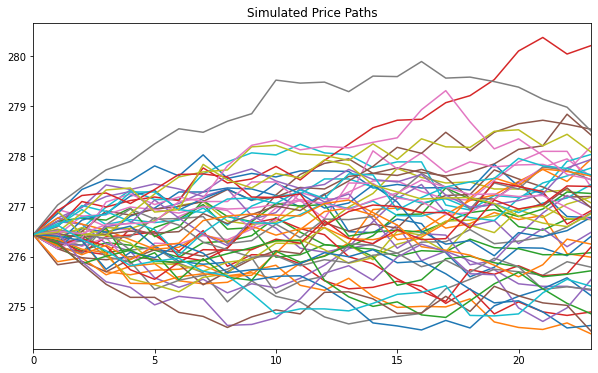

In [139]:
# Plot first 50 simulated paths
plt.figure(figsize=(10, 6))
plt.plot(lst_paths[0][:, :50]);
plt.xlim(0, d2x)
plt.title("Simulated Price Paths")

## Delta-Hedging
It is typical that a derivatives dealer will trade the above option with a customer, and then hold that option option until expiration and delta hedge it on a daily basis. Delta-hedging with daily rebalancing means at the end of each day we hold a position in the underlying who's size is equal to the negative of the delta of the option position. <br> 

The BSM manufacturing framework states that **the dealer will break even if**:

1. the underlying price follows a geometric brownian motion
2. the realized volatility during the life of the option is equal to the implied volatility used to price the option
3. the dealer delta-hedges with frequent rebalancing (in order for the result to be deterministic the delta-hedging must be continuous)

**If the dealer is *buying* the option and delta hedging, they will:**:
- Make money if implied volatility > realized volatility
- Lose money if implied volatility < realized volatility

**If the dealer is *selling* the option and delta hedging, they will:**:
- Lose money if implied volatility > realized volatility
- Make money if implied volatility < realized volatility


**Notes on Delta Hedging given initial portfolio:**<br>
If the initial portfolio is long a call or short a put: hedge with short underlying <br>
Rebalancing:
- If S goes down, buy delta shares of S
- If S goes up, sell delta shares of S
<br>

If the initial portfolio is short a call or long a put: hedge with long underlying <br>
Rebalancing:
- If S goes down, sell delta shares of S
- If S goes up, buy delta shares of S

### Delta-Hedging Simulation: when implied volatility = realized volatility


#### Using the `calcPnL` function, we'll do the following: <br>

1. Create a collection of dataframes that will track the PnL from delta-hedging the option for each option on each underlying.

2. Calculate the prices of the option for each day in the simulation using the `bsm_px()` function. <br>

2. Calculate the deltas through time using the `bsm_delta()` function.  <br>

3. Calculate the daily PnL on the option and the delta hedge

4. Calculate the total PnL of the position (total PnL = option PnL + delta hedge PnL) under each simulated price path scenario 


#### Calculate the daily PnL on the option, the hedge, and the total position

In [140]:
df_all_pnl = calcPnL(tickers = tickers, call_put = cp, strikes = strikes, imp_vols = pricing_vol, sim_paths = lst_paths,
                  hedge_freq = hedge_frequency, tenor = tenor, n_paths = num_paths, buy_sell = -1)

MSFT
GOOG


In [141]:
df_all_pnl

,underlying,cp,strike,volatility,upx,buy_sell,t2x,option_price,delta,option_pnl,delta_hedge_pnl,total_pnl,scenario
0,MSFT,p,270,0.0156,276.440002,-1,0.091270,0.0,-0.0,NaN,NaN,NaN,0
1,MSFT,p,270,0.0156,276.900000,-1,0.087302,0.0,-0.0,-0.0,-0.0,-0.0,0
2,MSFT,p,270,0.0156,276.450000,-1,0.083333,0.0,-0.0,-0.0,0.0,0.0,0
3,MSFT,p,270,0.0156,276.430000,-1,0.079365,0.0,-0.0,-0.0,0.0,0.0,0
4,MSFT,p,270,0.0156,276.810000,-1,0.075397,0.0,-0.0,-0.0,-0.0,-0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
23995,GOOG,p,108,0.0625,115.310000,-1,0.015873,0.0,-0.0,-0.0,-0.0,-0.0,499
23996,GOOG,p,108,0.0625,115.070000,-1,0.011905,0.0,-0.0,-0.0,0.0,0.0,499
23997,GOOG,p,108,0.0625,114.480000,-1,0.007937,0.0,-0.0,-0.0,0.0,0.0,499
23998,GOOG,p,108,0.0625,114.690000,-1,0.003968,0.0,-0.0,-0.0,-0.0,-0.0,499


In [142]:
# Calculate the PnL for each scenario for each option
df_scenario_pnl = df_all_pnl.groupby(['underlying', 'scenario'], as_index = False)[['total_pnl']].sum()
df_scenario_pnl

,underlying,scenario,total_pnl
0,GOOG,0,-0.00053
1,GOOG,1,-0.00057
2,GOOG,2,-0.00003
3,GOOG,3,-0.00019
4,GOOG,4,-0.00054
...,...,...,...
995,MSFT,495,0.00000
996,MSFT,496,0.00000
997,MSFT,497,0.00000
998,MSFT,498,0.00000


As the number of simulated price paths is lare, the average of the `total_pnls` approaches zero, which further demonstrates the manufacturing result of the Black-Scholes-Merton framework.

In [143]:
df_scenario_pnl.groupby(['underlying'], as_index = False)['total_pnl'].mean()

,underlying,total_pnl
0,GOOG,-0.000648
1,MSFT,0.000000


In [144]:
df_all_pnl['total_pnl'].mean()

-1.4082681672469416e-05

Is the delta-hedging reducing risk?

In [145]:
print(df_all_pnl.groupby('scenario')['option_pnl'].sum().std())
print(df_all_pnl.groupby('scenario')['total_pnl'].sum().std())

1.2537728023317516e-18
0.011428723244088996


Calculate the standard deviation, minimum, and maximum of the cumulative PNLs.

In [146]:
print(df_all_pnl.groupby('underlying')['total_pnl'].std())
print(df_all_pnl.groupby('underlying')['total_pnl'].min())
print(df_all_pnl.groupby('underlying')['total_pnl'].max())

underlying
GOOG    0.002301
MSFT    0.000000
Name: total_pnl, dtype: float64
underlying
GOOG   -0.16872
MSFT   -0.00000
Name: total_pnl, dtype: float64
underlying
GOOG    0.06568
MSFT   -0.00000
Name: total_pnl, dtype: float64


## Delta Hedging: What If Realized Volatility is Different than Pricing Volatility?

As we can see above, if the realized volatility of the underlying during the life of the option is equal to the pricing volatility, then the daily delta-hedging trader will break even on average (however, outcome can vary substantially depending on the scenario).

Now let's see what happens when realized volatility differs from pricing volatility.  In particular, we will see what happens when a trader sells an option, delta-hedges daily, but the realized volatility is 5% higher than implied.

In [147]:
# What if actual volatility is 10% higher than the implied volatility?
actual_vol = list(map(lambda x : x + .05, pricing_vol))
actual_vol

[0.0656, 0.1125]

In [148]:
# setting the random seed
np.random.seed(1)

# initializing paths
lst_paths = []

for i in range(0, len(tickers)):
    
    Xpaths = simPaths(ticker = tickers[i] , imp_vol = actual_vol[i], spot = spot_prices[i],
                       hedge_freq = hedge_frequency, n_paths = num_paths, delta_t = dt, rf_rate = risk_free)
       
    lst_paths.append(Xpaths)

In [152]:
df_all_pnl = calcPnL(tickers = tickers, call_put = cp, strikes = strikes, imp_vols = actual_vol, sim_paths = lst_paths,
                  hedge_freq = hedge_frequency, tenor = tenor, n_paths = num_paths, buy_sell = 1)

MSFT
GOOG


In [153]:
df_scenario_pnl = df_all_pnl.groupby(['underlying', 'scenario'], as_index = False)[['total_pnl']].sum()
df_scenario_pnl.groupby(['underlying'], as_index = False)['total_pnl'].mean()

,underlying,total_pnl
0,GOOG,-0.005898
1,MSFT,-0.006643


As we can see, since realized is greater than implied, we lose money on average.

In [154]:
df_all_pnl['total_pnl'].mean()

-0.00027264876671832897

## Increasing Delta-Hedge Frequency Reduces PNL Variability

See what happens to the dispersion of the distribution of the delta-hedge PNL outcomes when you double and quadruple the `hedge_frequency`.

In [155]:
new_hedge_frequency =  d2x*4
new_dt = tenor / new_hedge_frequency

In [156]:
# setting the random seed
np.random.seed(1)

# initializing paths
lst_paths_act_vol = []

for i in range(0, len(tickers)):
    
    Xpaths = simPaths(ticker = tickers[i] , imp_vol = pricing_vol[i], spot = spot_prices[i],
                       hedge_freq = new_hedge_frequency, n_paths = num_paths, delta_t = new_dt, rf_rate = risk_free)
       
    lst_paths_act_vol.append(Xpaths)

In [302]:
#len(lst_paths_act_vol[0])

In [158]:
df_all_pnl = calcPnL(tickers = tickers, call_put = cp, strikes = strikes, imp_vols = pricing_vol, sim_paths = lst_paths_act_vol,
                  hedge_freq = new_hedge_frequency, tenor = tenor, n_paths = num_paths, buy_sell = -1)

MSFT
GOOG


In [159]:
df_scenario_pnl = df_all_pnl.groupby(['underlying', 'scenario'], as_index = False)[['total_pnl']].sum()
df_scenario_pnl 

,underlying,scenario,total_pnl
0,GOOG,0,-0.00008
1,GOOG,1,0.00022
2,GOOG,2,0.00026
3,GOOG,3,0.00530
4,GOOG,4,-0.00021
...,...,...,...
995,MSFT,495,0.00000
996,MSFT,496,0.00000
997,MSFT,497,0.00000
998,MSFT,498,0.00000


#### You can see below that the standard deviation of the PnL is reduced when we increase hedging frequency

In [162]:
print(df_all_pnl.groupby('underlying')['total_pnl'].std())
print(df_all_pnl.groupby('underlying')['total_pnl'].min())
print(df_all_pnl.groupby('underlying')['total_pnl'].max())

underlying
GOOG    0.00055
MSFT    0.00000
Name: total_pnl, dtype: float64
underlying
GOOG   -0.02724
MSFT   -0.00000
Name: total_pnl, dtype: float64
underlying
GOOG    0.01419
MSFT   -0.00000
Name: total_pnl, dtype: float64
